# Generate figures for the paper

 
### Figure 1 
2015-2021(unconditional and conditional)
y axis (peak warming, eoc warming, difference of ghg emissions between 2025-2030, cum co2 (2020-2030, 2020-2050))
x axis (pathway date)

### Figure 2
Trajectories of latest pledges (conditional and unconditional)
bar chart with peak temps to compare sensisitivity cases vs the default

### Figure 3 (MM)
2030 GAPS 
2030 per capita emission

SR1.5 filtering? 

In [25]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [27]:
import datetime as dt
import logging
import os.path
from glob import glob
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scmdata
import seaborn as sns

from src.constants import PROCESSED_DATA_DIR, NDC_TARGET_RELEASE

<IPython.core.display.Javascript object>

In [28]:
plt.rcParams["figure.figsize"] = (12, 8)

<IPython.core.display.Javascript object>

In [29]:
CLIMATE_ASSESSMENT_ID = "20211125-ndc-methanePledges"
FNAME = f"output_{NDC_TARGET_RELEASE}_methanePledges.csv"

<IPython.core.display.Javascript object>

In [30]:
DATA_DIR = os.path.join(PROCESSED_DATA_DIR, "climate_assessment", CLIMATE_ASSESSMENT_ID)

<IPython.core.display.Javascript object>

# Fetch data from AWS

In [31]:
!aws s3 sync s3://ipcc-climate-assessment/{CLIMATE_ASSESSMENT_ID}/merged {DATA_DIR}

<IPython.core.display.Javascript object>

In [32]:
!ls {DATA_DIR}

batches				  emissions_batch_2_meta.xlsx
data				  merged
emissions_batch_1_alloutput.xlsx  out
emissions_batch_1_meta.xlsx	  raw_climate_output
emissions_batch_2_alloutput.xlsx  results_20211125-211305_meta.csv


<IPython.core.display.Javascript object>

## Load

In [33]:
alloutput_files = sorted(glob(os.path.join(DATA_DIR, "*_alloutput.xlsx")))
len(alloutput_files)

2

<IPython.core.display.Javascript object>

In [34]:
meta_files = sorted(glob(os.path.join(DATA_DIR, "*_meta.xlsx")))
len(meta_files)

2

<IPython.core.display.Javascript object>

In [35]:
# There are a couple of files that will not exist next time

<IPython.core.display.Javascript object>

In [36]:
all_files = []

for f in tqdm(meta_files):
    df = pd.read_excel(f)
    df["file"] = f
    all_files.append(df)
    
all_meta = pd.concat(all_files)


  0%|          | 0/2 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [37]:
all_meta[all_meta.duplicated("scenario", False)][["scenario", "file"]]["file"].unique()

array([], dtype=object)

<IPython.core.display.Javascript object>

In [38]:
alloutput_files = [alloutput_files[i] for i in range(len(alloutput_files))]

<IPython.core.display.Javascript object>

In [39]:
len(alloutput_files)

2

<IPython.core.display.Javascript object>

In [40]:
alloutput_merged = scmdata.run_append(
    [scmdata.ScmRun(f, lowercase_cols=True) for f in tqdm(alloutput_files)]
)

  0%|          | 0/2 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [41]:
alloutput_merged.head()

time                                                                                                                             1995-01-01  \
model         region scenario                                           unit variable                                                         
NDC Factsheet World  2021-11-03_1__high__C__SSP1BL__exclude__conditi... ppb  AR6 climate diagnostics|Atmospheric Concentrati...     1755.23   
                                                                             AR6 climate diagnostics|Atmospheric Concentrati...     1755.23   
                                                                             AR6 climate diagnostics|Atmospheric Concentrati...     1755.23   
                                                                             AR6 climate diagnostics|Atmospheric Concentrati...     1755.23   
                                                                             AR6 climate diagnostics|Atmospheric Concentrati...     1755.23   

time                                                                                                                             1996-01-01  \
model         region scenario                                           unit variable                                                         
NDC Factsheet World  2021-11-03_1__high__C__SSP1BL__exclude__conditi... ppb  AR6 climate diagnostics|Atmospheric Concentrati...     1757.19   
                                                                             AR6 climate diagnostics|Atmospheric Concentrati...     1757.19   
                                                                             AR6 climate diagnostics|Atmospheric Concentrati...     1757.19   
                                                                             AR6 climate diagnostics|Atmospheric Concentrati...     1757.19   
                                                                             AR6 climate diagnostics|Atmospheric Concentrati...     1757.19   

time                                                                                                                             1997-01-01  \
model         region scenario                                           unit variable                                                         
NDC Factsheet World  2021-11-03_1__high__C__SSP1BL__exclude__conditi... ppb  AR6 climate diagnostics|Atmospheric Concentrati...      1761.5   
                                                                             AR6 climate diagnostics|Atmospheric Concentrati...      1761.5   
                                                                             AR6 climate diagnostics|Atmospheric Concentrati...      1761.5   
                                                                             AR6 climate diagnostics|Atmospheric Concentrati...      1761.5   
                                                                             AR6 climate diagnostics|Atmospheric Concentrati...      1761.5   

time                                                                                                                             1998-01-01  \
model         region scenario                                           unit variable                                                         
NDC Factsheet World  2021-11-03_1__high__C__SSP1BL__exclude__conditi... ppb  AR6 climate diagnostics|Atmospheric Concentrati...     1770.29   
                                                                             AR6 climate diagnostics|Atmospheric Concentrati...     1770.29   
                                                                             AR6 climate diagnostics|Atmospheric Concentrati...     1770.29   
                                                                             AR6 climate diagnostics|Atmospheric Concentrati...     1770.29   
                                                                             AR6 climate diagnostics|Atmospheric Concentrati...     1770

<IPython.core.display.Javascript object>

In [42]:
alloutput_cleaned = []

for s in alloutput_merged.groupby("scenario"):
    try:
        (
            pathway_id,
            ambition,
            conditionality,
            extension,
            exclude_hot_air,
        ) = s.get_unique_meta("scenario", True).split("__")
        methane_pledges = ""
    except:
        (
            pathway_id,
            ambition,
            conditionality,
            extension,
            exclude_hot_air,
            methane_pledges,
        ) = s.get_unique_meta("scenario", True).split("__")

    s["pathway_id"] = pathway_id
    s["ambition"] = ambition
    s["conditionality"] = conditionality
    s["country_extension"] = extension
    s["exclude_hot_air"] = exclude_hot_air
    s["methane_pledges"] = methane_pledges

    alloutput_cleaned.append(s)

alloutput_cleaned = scmdata.run_append(alloutput_cleaned)

<IPython.core.display.Javascript object>

In [43]:
alloutput_cleaned["variable"] = [
    v[len("AR6 climate diagnostics|") :] for v in alloutput_merged["variable"]
]

<IPython.core.display.Javascript object>

In [44]:
# alloutput_cleaned.get_unique_meta("variable")

<IPython.core.display.Javascript object>

In [45]:
OUT_FNAME = os.path.join(DATA_DIR, "../merged", FNAME)
OUT_FNAME

'/data2/ubuntu-mmeinshausen/unfccc-ndc/src/../data/processed/climate_assessment/20211125-ndc-methanePledges/../merged/output_12Nov2021a_CR_methanePledges.csv'

<IPython.core.display.Javascript object>

In [46]:
alloutput_cleaned.to_csv(OUT_FNAME)

<IPython.core.display.Javascript object>

In [47]:
# Lets see how big the output is
!ls -lh {OUT_FNAME}

-rw-rw-r-- 1 ubuntu ubuntu 2.6M Nov 26 05:04 /data2/ubuntu-mmeinshausen/unfccc-ndc/src/../data/processed/climate_assessment/20211125-ndc-methanePledges/../merged/output_12Nov2021a_CR_methanePledges.csv


<IPython.core.display.Javascript object>

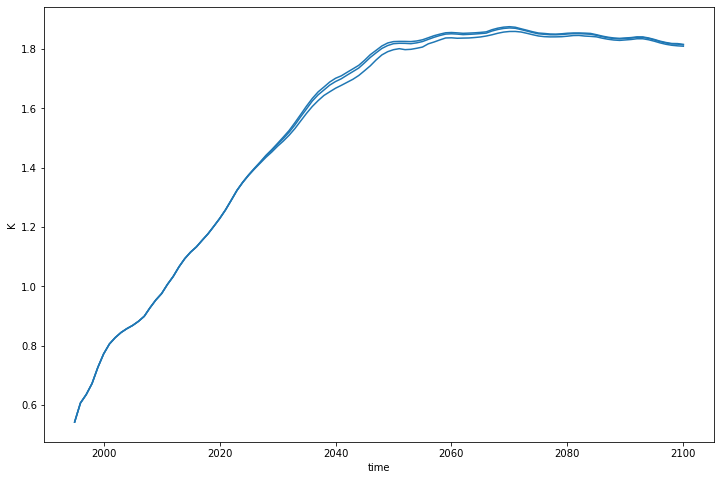

<IPython.core.display.Javascript object>

In [48]:
for v in ["Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile"]:
    plt.figure()

    alloutput_cleaned.filter(variable=v).lineplot(
        hue="variable", estimator=None, units="scenario", legend=False
    )

In [49]:
# alloutput_cleaned.filter(
#     pathway_id="2021-11-09_1",
#     variable="Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile",
# ).lineplot()

<IPython.core.display.Javascript object>